# PCA Tutorial 1

Venkatakrishnan E, Rishabh Mondal  
2024-10-30

<figure>
<a
href="https://colab.research.google.com/github/nipunbatra/ml-teaching/blob/master/notebooks/pca-tutorial-1.ipynb"><img
src="https://colab.research.google.com/assets/colab-badge.svg" /></a>
<figcaption>Open In Colab</figcaption>
</figure>

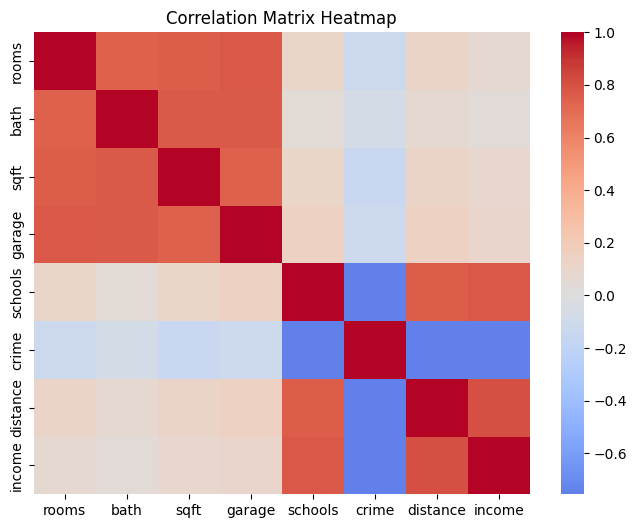

Covariance Matrix:
                rooms        bath           sqft      garage      schools  \
rooms       1.170565    0.578442     226.712141    0.402969     0.165186   
bath        0.578442    0.520655     153.051205    0.265776     0.042117   
sqft      226.712141  153.051205   76365.107914   98.431732    41.912809   
garage      0.402969    0.265776      98.431732    0.229164     0.096007   
schools     0.165186    0.042117      41.912809    0.096007     2.052282   
crime      -1.244739   -0.508013    -380.886596   -0.521502   -10.258421   
distance    0.234267    0.091537      57.394686    0.133176     2.052900   
income    590.375758  190.326319  177182.411264  363.295200  8387.138229   

                 crime      distance        income  
rooms        -1.244739      0.234267  5.903758e+02  
bath         -0.508013      0.091537  1.903263e+02  
sqft       -380.886596     57.394686  1.771824e+05  
garage       -0.521502      0.133176  3.632952e+02  
schools     -10.258421      2.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)
n = 200

mean1 = np.zeros(4)
cov1 = np.full((4,4), 0.8)
np.fill_diagonal(cov1, 1)
group1 = np.random.multivariate_normal(mean1, cov1, n)

mean2 = np.zeros(4)
cov2 = np.full((4,4), 0.8)
np.fill_diagonal(cov2, 1)
group2 = np.random.multivariate_normal(mean2, cov2, n)

data = np.hstack((group1, group2))
df = pd.DataFrame(data, columns=["rooms", "bath", "sqft", "garage",
                                 "schools", "crime", "distance", "income"])

df["rooms"] = 3 + df["rooms"] * 1.2
df["bath"] = 2 + df["bath"] * 0.8
df["sqft"] = 1500 + df["sqft"] * 300
df["garage"] = 1 + df["garage"] * 0.5
df["schools"] = 5 + df["schools"] * 1.5
df["crime"] = 50 - df["crime"] * 10
df["distance"] = 10 + df["distance"] * 2
df["income"] = 60000 + df["income"] * 8000

corr = df.corr()
cov = df.cov()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Matrix Heatmap")
plt.show()

print("Covariance Matrix:\n", cov)



Reconstruction Error Comparison:
PCA Reconstruction Error: 0.003529
MLP Autoencoder Error:    0.009015
CNN Autoencoder Error:    0.001090

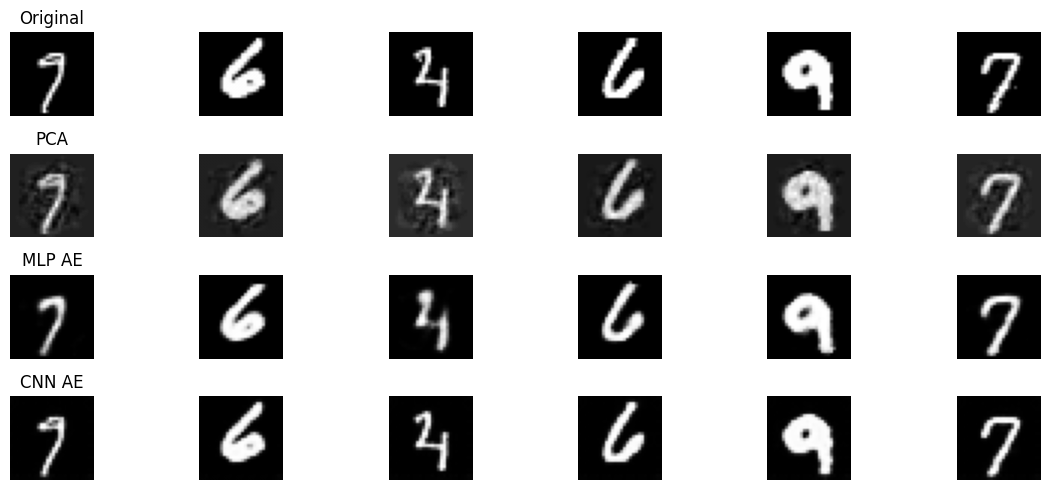

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

batch_size = 128
latent_dim = 64
num_epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
images, _ = next(iter(loader))
images = images.to(device)
images_flat = images.view(images.size(0), -1).cpu().numpy()

# PCA Reconstruction
pca = PCA(n_components=latent_dim)
imgs_pca = pca.inverse_transform(pca.fit_transform(images_flat))

# MLP Autoencoder
class MLP_Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        out = self.decoder(z)
        return out.view(-1, 1, 28, 28)

mlp_model = MLP_Autoencoder(latent_dim).to(device)
optimizer = optim.Adam(mlp_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    for imgs, _ in loader:
        imgs = imgs.to(device)
        out = mlp_model(imgs)
        loss = criterion(out, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

mlp_out = mlp_model(images).detach().cpu()

# CNN Autoencoder
class CNN_Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

cnn_model = CNN_Autoencoder().to(device)
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    for imgs, _ in loader:
        imgs = imgs.to(device)
        out = cnn_model(imgs)
        loss = criterion(out, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

cnn_out = cnn_model(images).detach().cpu()

# Reconstruction Error Comparison
pca_error = mean_squared_error(images_flat, imgs_pca)
mlp_error = mean_squared_error(images_flat, mlp_out.view(images.size(0), -1).numpy())
cnn_error = F.mse_loss(cnn_out, images.cpu()).item()

print(f"\nReconstruction Error Comparison:")
print(f"PCA Reconstruction Error: {pca_error:.6f}")
print(f"MLP Autoencoder Error:    {mlp_error:.6f}")
print(f"CNN Autoencoder Error:    {cnn_error:.6f}")

# Visualization
def show_reconstructions(original, pca, mlp, cnn, n=6):
    plt.figure(figsize=(12, 5))
    for i in range(n):
        # Original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(original[i][0], cmap="gray")
        ax.axis("off")
        if i == 0:
            ax.set_title("Original")

        # PCA
        ax = plt.subplot(4, n, i + 1 + n)
        plt.imshow(pca[i].reshape(28, 28), cmap="gray")
        ax.axis("off")
        if i == 0:
            ax.set_title("PCA")

        # MLP
        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(mlp[i][0], cmap="gray")
        ax.axis("off")
        if i == 0:
            ax.set_title("MLP AE")

        # CNN
        ax = plt.subplot(4, n, i + 1 + 3*n)
        plt.imshow(cnn[i][0], cmap="gray")
        ax.axis("off")
        if i == 0:
            ax.set_title("CNN AE")
    plt.tight_layout()
    plt.show()

show_reconstructions(images.cpu(), imgs_pca, mlp_out, cnn_out)
